# P4 winter data visualization challenge

Marina Vabistsevits

2022-12-12

<br>

## Winter critical care hospital occupancy in Bristol for adults, children, and infants (2018-2019, pre-COVID)



Challenge details: [https://github.com/MRCIEU/P4winter-viz-challenge](https://github.com/MRCIEU/P4winter-viz-challenge)

Data from NHS England: [Winter SitRep: Acute Time series 3 December 2018 to 3 March 2019 (XLSX, 1480kB)](https://www.england.nhs.uk/statistics/statistical-work-areas/winter-daily-sitreps/winter-daily-sitrep-2018-19-data/)

Visualisation tools: R packages **circilize** ([https://github.com/jokergoo/circlize](https://github.com/jokergoo/circlize)) and **ComplexHeatmap** (Bioconductor)

<br>

### Background

The dataset contains critical care bed occupancy in all NHS Trusts across England from December 2018 to February 2019 (pre-COVID data). 

In this analysis/visualisation, I will focus on Bristol data only. Hospitals in Bristol are split between two NHS Trusts - _North Bristol NHS Trust_ and _University Hospitals Bristol and Weston NHS Foundation Trust_, which cover the north and centre/south of the city, respectively. For context, below is the list of hospitals that belong to the two trusts [[source](https://en.wikipedia.org/wiki/Healthcare_in_Bristol)]:


North Bristol NHS Trust  (**NBT**) manages hospitals in the north of Bristol and South Gloucestershire.

- Southmead Hospital
- Cossham Memorial Hospital
- Frenchay Hospital


University Hospitals Bristol and Weston NHS Foundation Trust (**UHB**) manages hospitals in the centre and south of the city, and at Weston-super-Mare.

- Bristol Royal Infirmary (BRI)
- Bristol Heart Institute
- Bristol Haematology and Oncology Centre
- South Bristol Community Hospital
- Bristol Royal Hospital for Children 
- St. Michael's Hospital
- Bristol Eye Hospital
- University of Bristol Dental Hospital

### Analysis

We are going to look at critical care bed occupancy for adults, children (<14 years), and infants (<6 months) in these two Bristol-based NHS Trusts (NBT & UHB), and visualise how occupancy changed over the winter months (especially during the holidays period! `r emo::ji("christmas")`)


In [1]:
library(dplyr, warn.conflicts=FALSE)
library(tidyr)
library(tibble)
library(openxlsx)
library(kableExtra, warn.conflicts=FALSE)
suppressPackageStartupMessages(library(lubridate))

suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(circlize))

# options for jupyter
options(warn=-1)
options(jupyter.plot_scale=1)

filename ="Winter-data-timeseries-20190307.xlsx"

In [2]:
kable_it<-function(df){
  df %>%
    kable(.) %>%
    kable_styling()
}

#### Load data

Reading the xls file and converting the data into the long format.


In [3]:
# functions 
load_data <- function(file, sheet){
      
      # read the dat in the specified sheet
      dat<- read.xlsx(xlsxFile = file, 
                        fillMergedCells = TRUE, colNames = FALSE, 
                        sheet = sheet, rows = c(13:151))
      
      # store NHS trust names and location separately
      nhs_labels <- dat %>% select(region = X1, code = X3, Name= X4)
      nhs_labels <- nhs_labels[5:nrow(nhs_labels),]
      
      # store main data
      data_values <- dat %>% select(X4:X277)
      
      # vector of dates read in numerical format
      dates_numerical <- data_values[2, 2:274]
      # vector of value types
      colnames_vector <- data_values[3, 2:274]
      
      # create value type+date vector
      new_names <-paste(colnames_vector, dates_numerical,sep='_')
      
      # keep only values + add new colnames
      data_values_only <- data_values[4:138,1:274]
      colnames(data_values_only) <- c("Name", new_names )
      
      # pivot data to long format; split type_date; convert date_numerical to Date; add NHS Trust labels
      out <- data_values_only %>% 
                 pivot_longer(!Name, names_to = "variable", values_to = "value") %>% 
                 separate(col=variable, into=c("variable", "date"), sep = "_") %>% 
                 mutate(date = openxlsx::convertToDate(date)) %>% 
                 left_join(nhs_labels, by = "Name") %>% 
                 arrange(region)
      return(out)
}


dat_adult <- load_data(file = filename, sheet = "Adult critical care")
dat_adult %>% head()

Name,variable,date,value,region,code
<chr>,<chr>,<date>,<chr>,<chr>,<chr>
"Barking, Havering and Redbridge University Hospitals NHS Trust",CC Adult Open,2018-12-03,52,London Commissioning Region,RF4
"Barking, Havering and Redbridge University Hospitals NHS Trust",CC Adult Occ,2018-12-03,43,London Commissioning Region,RF4
"Barking, Havering and Redbridge University Hospitals NHS Trust",Occupancy rate,2018-12-03,0.82692307692307687,London Commissioning Region,RF4
"Barking, Havering and Redbridge University Hospitals NHS Trust",CC Adult Open,2018-12-04,52,London Commissioning Region,RF4
"Barking, Havering and Redbridge University Hospitals NHS Trust",CC Adult Occ,2018-12-04,46,London Commissioning Region,RF4
"Barking, Havering and Redbridge University Hospitals NHS Trust",Occupancy rate,2018-12-04,0.88461538461538458,London Commissioning Region,RF4


#### Process data

Subsetting the data to Bristol NHS Trusts, and extracting bed occupancy rates for each date in the two NHS Trusts.

In [4]:
process_data <- function(data){
      
      # subset to Bristol
      data_region <- data %>% 
                mutate(value=as.numeric(value)) %>% 
                filter(grepl("Bristol", Name)) %>% 
                mutate(abbr = case_when(Name == "University Hospitals Bristol NHS Foundation Trust" ~ "UHB",
                                        Name == "North Bristol NHS Trust" ~"\nNBT"))
              
      # keep only Occupancy data
      data_region_occ <- data_region %>% 
                filter(grepl("Occupancy", variable))
        
      # pivot data to wide format
      data_region_occ_wide <- data_region_occ %>% 
                 pivot_wider(id_cols=date, names_from = abbr, values_from = value, values_fill = NA) %>% 
                 # extarct month from the date and create column with month name labels (set order with factor)
                 mutate(month = lubridate::month(date, label=T, abbr=F)) %>%
                 filter(month %in% c("December", "January" , "February")) %>% 
                 mutate(month = factor(month, levels = c("December", "January" , "February"))) %>% 
                 # create dat in 01-Dec format for the plot
                 mutate(DayDate=lubridate::day(date)) %>%
                 mutate(MonthDate=month(date, label=T)) %>%
                 unite(DayMonth, c("DayDate", "MonthDate"), sep = "-")
        
      # keep month labels as a separate variable - will be used in viz for sectors
      split <- data_region_occ_wide$month
      
      # tidy the output
      data_region_occ_wide<-
                 data_region_occ_wide %>% 
                 column_to_rownames('DayMonth') %>% 
                 select( "UHB",  "\nNBT") # arrange in the order to appear on the plot
      
      return(list(
        full_bristol_data = data_region,
        wide_data = data_region_occ_wide,
        split = split
  ))
}

dat_adult_bristol <- process_data(dat_adult)
dat_adult_bristol$wide_data %>% head() 

,UHB,NBT
,<dbl>,<dbl>
3-Dec,0.8727273,0.6521739
4-Dec,0.9090909,0.6739130
5-Dec,0.9636364,0.7608696
6-Dec,0.9818182,0.7391304
7-Dec,0.9090909,0.7826087
8-Dec,0.8181818,0.8043478


#### Visualise data (circular heatmap)



In [5]:
plot_circular_heatmap <- function(df,  title_prefix){
      # https://jokergoo.github.io/circlize_book/book/circos-heatmap.html
      
      split <- df$split
      df<- df$wide_data
    
      # create color palette green-white-red (min to max occupancy)
      vals <- c(df$`\nNBT`, df$`UHB`)
      min <- round(min(vals[!is.na(vals)]),1)
      mid = (1+min)/2
      col_fun1 = colorRamp2(c(min, mid ,1), c("#0F3C28", "white", "#A7111C"))
      
      # build plot by layers
      circos.clear()
      circos.par( gap.degree = c(5,5,20), start.degree = 150) 
      circos.heatmap(df,  col = col_fun1, track.height = 0.4, rownames.side = "outside", 
                     cluster=F, split = split, show.sector.labels = T,
                     bg.border = "grey", bg.lwd = 1, bg.lty = 1)
      
      circos.track(track.index = get.current.track.index(), panel.fun = function(x, y) {
        if(CELL_META$sector.numeric.index == 1) { # the last sector
          cn = rev(colnames(df))
          n = length(cn)
          circos.text(x = rep(CELL_META$cell.xlim[2]+64, n) + convert_x(1, "mm"),  # 64 is a magic number, it moves track labels clockwise
                      y = 1:n - 3, 
                      labels = cn, 
                      cex = 0.8, 
                      adj = c(0, 1), 
                      facing = "inside")
        }
      }, bg.border = NA)
      lgd = Legend(title = paste0(title_prefix,"\nbed occupancy"), col_fun = col_fun1)
      grid.draw(lgd)
}


### Adult critical care


NULL

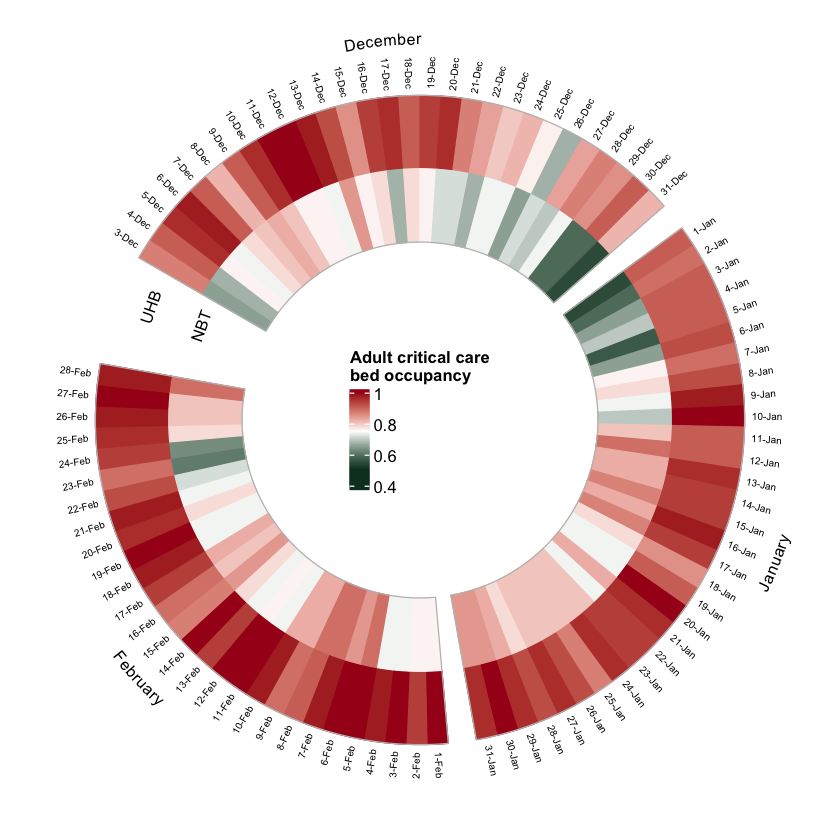

In [6]:
suppressMessages( 
    p<- plot_circular_heatmap(df=dat_adult_bristol,  "Adult critical care"))
p

 - UBH (n_beds=55) was very busy during the entire winter season (mean occupancy 93%) 
 - The only days with occupancy < 80% at UHB were Christmas and Boxing Days `r emo::ji("christmas")`
 - NBT (n_beds=46) was busy too (mean occupancy 76%), but there were fewer people in critical care in NBT over the entire holiday season (~ 20-Dec to 6-Jan) `r emo::ji("christmas")`)


In [7]:
# mean occupancy
round(colMeans(dat_adult_bristol$wide_data),2)

UHB \nNBT 
 0.93  0.76

In [8]:
# show the total number of available beds in each NHS Trust
dat_adult_bristol$full_bristol_data  %>% 
  select(Name, abbr, variable, open_beds = value) %>% 
  mutate(abbr = gsub("\n", "", abbr)) %>% 
  filter(variable == "CC Adult Open") %>% 
  count(Name, abbr, open_beds) %>% filter(n>1) %>% select(-n)  %>% kable_it()

<table class="table" style="margin-left: auto; margin-right: auto;">
 <thead>
  <tr>
   <th style="text-align:left;"> Name </th>
   <th style="text-align:left;"> abbr </th>
   <th style="text-align:right;"> open_beds </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> North Bristol NHS Trust </td>
   <td style="text-align:left;"> NBT </td>
   <td style="text-align:right;"> 46 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> University Hospitals Bristol NHS Foundation Trust </td>
   <td style="text-align:left;"> UHB </td>
   <td style="text-align:right;"> 55 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> University Hospitals Bristol NHS Foundation Trust </td>
   <td style="text-align:left;"> UHB </td>
   <td style="text-align:right;"> 57 </td>
  </tr>
</tbody>
</table>

<br>

### Paediatric intensive care

Children (< 14 years)


NULL

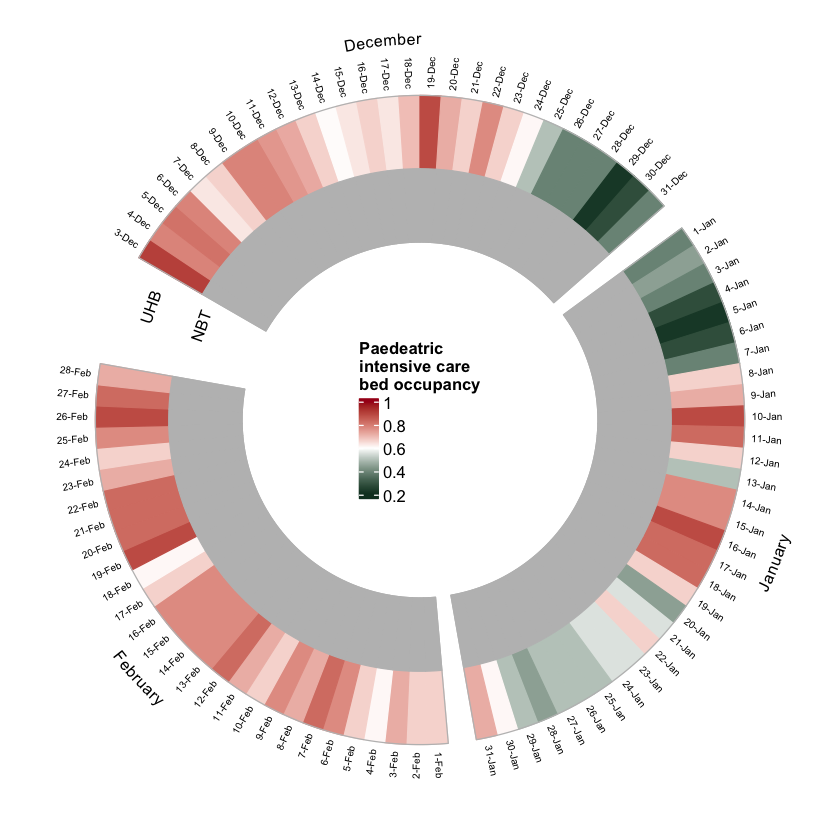

In [9]:
dat_child <- load_data(file = filename,  sheet = "Paediatric intensive care")
dat_child_bristol <- process_data(dat_child)
suppressMessages(
    p <- plot_circular_heatmap(df=dat_child_bristol,  "Paedeatric \nintensive care"))
p

- Paediatric intensive care in Bristol is only available at UHB (likely at the _Bristol Royal Hospital for Children_)
- Therefore, no data is presented for NBT in the plot
- There was quite "low" bed occupancy in the paediatric unit between 25-Dec and 7-Jan: < 50% `r emo::ji("christmas")` `r emo::ji("christmas")` `r emo::ji("christmas")`


In [10]:
# mean occupancy
round(colMeans(dat_child_bristol$wide_data),2)

UHB \nNBT 
 0.65    NA

In [11]:
# show the total number of available beds in each NHS Trust
dat_child_bristol$full_bristol_data  %>% 
  select(Name, abbr, variable, open_beds = value) %>% 
  filter(variable == "Paed Int Care Open") %>% 
  mutate(abbr = gsub("\n", "", abbr)) %>% 
  count(Name, abbr, open_beds) %>% select(-n) %>% kable_it()


<table class="table" style="margin-left: auto; margin-right: auto;">
 <thead>
  <tr>
   <th style="text-align:left;"> Name </th>
   <th style="text-align:left;"> abbr </th>
   <th style="text-align:right;"> open_beds </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> North Bristol NHS Trust </td>
   <td style="text-align:left;"> NBT </td>
   <td style="text-align:right;"> 0 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> University Hospitals Bristol NHS Foundation Trust </td>
   <td style="text-align:left;"> UHB </td>
   <td style="text-align:right;"> 18 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> University Hospitals Bristol NHS Foundation Trust </td>
   <td style="text-align:left;"> UHB </td>
   <td style="text-align:right;"> 33 </td>
  </tr>
</tbody>
</table>

### Neonatal intensive care (NICU)

Infants (< 6 months)


NULL

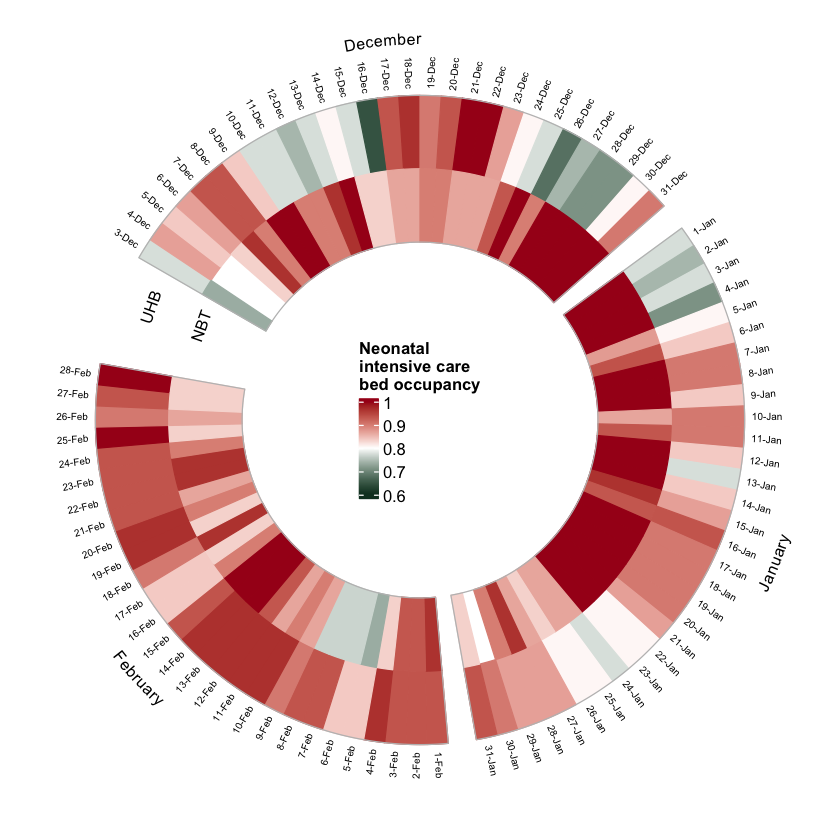

In [12]:
dat_baby <- load_data(file = filename, sheet = "Neonatal intensive care ")
dat_baby_bristol <- process_data(dat_baby)
suppressMessages(
    p <- plot_circular_heatmap(df=dat_baby_bristol,  "Neonatal \nintensive care "))
p

- NBT and UHB have a similar number of NICU beds (30/31)
- NBT was busier (92% mean occupancy), with 100% beds taken from 24-Dec to 23-Jan
- At UHB a smaller number of beds were occupied from 24-Dec to 5-Jan `r emo::ji("christmas")`


In [13]:
# mean occupancy
round(colMeans(dat_baby_bristol$wide_data),2)

UHB \nNBT 
 0.87  0.92

In [14]:
# show the total number of available beds in each NHS Trust
dat_baby_bristol$full_bristol_data  %>%
  select(Name, abbr, variable, open_beds = value) %>% 
  filter(variable == "Neo Int Care Open") %>% 
  mutate(abbr = gsub("\n", "", abbr)) %>% 
  count(Name, abbr, open_beds) %>% filter(n>10) %>% select(-n)  %>% kable_it()

<table class="table" style="margin-left: auto; margin-right: auto;">
 <thead>
  <tr>
   <th style="text-align:left;"> Name </th>
   <th style="text-align:left;"> abbr </th>
   <th style="text-align:right;"> open_beds </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> North Bristol NHS Trust </td>
   <td style="text-align:left;"> NBT </td>
   <td style="text-align:right;"> 30 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> University Hospitals Bristol NHS Foundation Trust </td>
   <td style="text-align:left;"> UHB </td>
   <td style="text-align:right;"> 31 </td>
  </tr>
</tbody>
</table>

<br>
<br>

#### Final thoughts

- Critical care bed occupancy was high during the winter season pre-Covid
- High occupancy in neonatal intensive care may not be winter-season related
- Overall, there were less adults and children in critical care over the holiday season `r emo::ji("christmas")` `r emo::ji("christmas")` `r emo::ji("christmas")`

<br>

<center>

![](https://media.tenor.com/iLT5yyoJg2oAAAAC/christmas-miracle.gif)

</center>
